<a href="https://colab.research.google.com/github/Dudgit/Feri/blob/main/miskei_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Importing the neccessary libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.lines import Line2D

from math import sin, cos, exp, pi, log
import math

from keras.layers import Reshape, Dense, Flatten, Input, Conv1D, Conv2D, Conv2DTranspose, Cropping2D, Concatenate, LocallyConnected1D, ZeroPadding2D
from keras.layers.core import Reshape
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import utils as np_utils

from sklearn.model_selection import train_test_split

# Functions

### Function for generating the domain

In [ ]:
# Function for generating the domain
 
# Input0: the width of the main rectangle
# Input1: the height of the main rectangle
# Input2: the width of the triangluar part
# Input3: the border_dist - sets the distance of the border from the cirucmference
# Input4: the density of points on the border per unit length
# Input5: n for the n-gon
# Input6: (s) BASE for the number of inner training points (the X in X^2 = number_of_extra_training_points_inside)

# Output1: x coordinates on ∂Ω
# Output1: y coordinates on ∂Ω
# Output2   list of x coordinates on ∂Ω+ε
# Output3   list of y coordinates on ∂Ω+ε
# Output4   list of x coordinates of inner measuring points on the regular n-gon
# Output5   list of y coordinates of inner measuring points on the ragular n-gon
# Output6   list of x coordinates of the other inner measuring points
# Output7   list of y coordinates of the other inner measuring points

def mydomain(rectangle_width, rectangle_height, triangle_width, border_dist, density, n_gon, s):
    a = rectangle_width   
    b = rectangle_height    
    c = triangle_width    
    d = border_dist
    N = n_gon
    rho = density         
    
    # Creating lists to save the coordinates
    x_coord_circ = []
    y_coord_circ = []
    
    x_border = []
    y_border = []

    # Generating the coordinates of the border with density rho
    x_lower = np.linspace(0, a + c, int(rho * (a + c) + 1))
    y_lower = [0]*(len(x_lower))

    y_left = np.linspace(b, 0, int(rho * b + 1))
    x_left = [0]*len(y_left)

    x_upper = x_lower[0:int(rho * a + 1)][::-1]
    y_upper = [b]*len(x_upper)

    x_diag = np.linspace(a + c, a, int(rho * c + 1))
    y_diag = -(b/c) * x_diag + b*(a+c)/c * np.ones(len(x_diag))

    x_coord_circ = np.concatenate((x_left, x_lower, x_diag, x_upper)) #connecting the border coordinates into a single vector
    y_coord_circ = np.concatenate((y_left, y_lower, y_diag, y_upper))

####################################################################################  
  
    # Generating the separate circumference
    x_lower_sep = x_lower
    y_lower_sep = (-1) * d * np.ones(len(y_lower))

    x_left_sep = (-1) * d * np.ones(len(x_left))
    y_left_sep = y_left

    x_upper_sep = x_upper
    y_upper_sep = y_upper + d * np.ones(len(y_upper))

    x_diag_sep = x_diag + (d * b) / np.sqrt(b**2 + c**2) * np.ones(len(x_diag))
    y_diag_sep = y_diag + (d * c) / np.sqrt(b**2 + c**2) * np.ones(len(y_diag))

    x_coord_circ_sep = np.concatenate((x_left_sep, [-0.7071067811865475244*d], x_lower_sep, [a + c + d *np.cos(0.5*np.arctan((-1)*b/c))], x_diag_sep, [a + d *np.cos(0.5 * np.pi + 0.5*np.arctan((-1)*b/c))], x_upper_sep, [-0.7071067811865475244*d], [x_left_sep[0]]))
    y_coord_circ_sep = np.concatenate((y_left_sep, [-0.7071067811865475244*d], y_lower_sep, [d *np.sin(0.5*np.arctan((-1)*b/c))], y_diag_sep, [b + d *np.sin(0.5 * np.pi + 0.5*np.arctan((-1)*b/c))], y_upper_sep, [b+0.7071067811865475244*d], [y_left_sep[0]]))
####################################################################################

    [x_circcenter, y_circcenter] = [0.5 * a + 0.25 * c, 0.5 * b] #midpoint of trapezoid
    r_circ = min(0.25 * b, 0.125 * (2 * a + c), 0.25 * (2 * a + 3 * c)/(a + c)) #radius of circle on whose circumference the inner points are situated - less than the closest border point
    theta = np.linspace(0, 2 * np.pi, N+1) #θ=k*2π/n, k=0,...,n-1
    [inner_x, inner_y] = [0.25 * (2 * a + c) + r_circ * np.cos(theta), 0.5 * b + r_circ * np.sin(theta)] # r distance and θ angle away from midpoint of trapezoid

####################################################################################    

    #creating a relatively rough mesh of X^2 points for the inner training points

    belso_1 = np.zeros(s ** 2)
    belso_2 = np.zeros(s ** 2)
    for i in range(0, s):
      belso_1[i*s:i*s+s] = np.linspace(0, (a*b + c*(b - (i+1)*b/(s+1)))/b, s+2)[1:s+1]
      for j in range(0, s):
        belso_2[j * s + i] = (j + 1) * b / (s + 1)
        # belso_1[j * s + i] = (j + 1) * (a*b + c*(b - belso_2[j * s + i]))/(b*(1 + s))
    belso_1 = np.reshape(belso_1, s**2)
    belso_2 = np.reshape(belso_2, s**2)

    #for i in range(0,len(belso_1)):
      #belso_1[i] = (1 + (-1/b + 1/(a + c))*belso_2[i])*belso_1[i]
    
    # ind_tor = np.where(b*belso_1+c*belso_2 > b*(a+c))[0]
    # np.delete(belso_1, ind_tor)
    # np.delete(belso_2, ind_tor)

    inner_measured = [belso_1, belso_2]

    
    # Returning the coordinates
    return [x_coord_circ, y_coord_circ, x_coord_circ_sep, y_coord_circ_sep, inner_x, inner_y, belso_1, belso_2]

### Function for plotting the domain

In [ ]:
# Function for plotting the domain

# Input0: x coordinates of the circumference
# Input1: y coordinates of the circumference
# Input2: x coordinates of the inner domain
# Input3: y coordinates of the inner domain
# Input4: x coordinates of the border
# Input5: y coordinates of the border
# Input6: visibility of certain features of the domain
# Input7: savefig boolean - if true, the figure is saved as "domain.jpg"

# Output: a nice plot of the domain

def rect_plot(border_coord, circum_coord, border_training_coord, circum_training_coord, inner_measured, inner_training_coord, visibility, savefig):

    plt.figure(figsize = (10,10))
    plt.grid()
    
    custom_lines = []
    custom_legend_label = []
    
    if visibility[0] == True:
        plt.scatter(border_coord[0], border_coord[1], color = 'navy', s = 20)
        custom_lines.append(Line2D([0], [0], color='navy', lw=5))
        custom_legend_label.append('Outer points')
    
    if visibility[1] == True:
        plt.scatter(circum_coord[0], circum_coord[1], color = 'cyan', s = 20)
        custom_lines.append(Line2D([0], [0], color='cyan', lw=5))
        custom_legend_label.append('∂Ω')

    if visibility[2] == True:
        plt.scatter(border_training_coord[0], border_training_coord[1], color = 'cyan', s = 20)
        custom_lines.append(Line2D([0], [0], color='cyan', lw=5))
        custom_legend_label.append('Border training points')

    if visibility[3] == True:
        plt.scatter(circum_training_coord[0], circum_training_coord[1], color = 'dodgerblue', s = 20)
        custom_lines.append(Line2D([0], [0], color='dodgerblue', lw=5))
        custom_legend_label.append('Training points on ∂Ω')
        
    if visibility[4] == True:
        plt.scatter(inner_measured[0], inner_measured[1], color = 'springgreen', s = 80)
        custom_lines.append(Line2D([0], [0], color='springgreen', lw=5))
        custom_legend_label.append('Measured points in intΩ')
        
    if visibility[5] == True:
        plt.scatter(inner_training_coord[0], inner_training_coord[1], color = 'purple', s = 20)
        custom_lines.append(Line2D([0], [0], color='purple', lw=5))
        custom_legend_label.append('Inner training points')
      
    plt.title('The generated domain with width = ' + str(rectangle_width + triangle_width) + ', height = ' + str(rectangle_height), fontsize = 18, y = 1.05)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('y', fontsize = 14)    
    plt.legend(custom_lines, custom_legend_label, bbox_to_anchor=(1.05, 1), loc=2, fontsize = 15)
    
    if savefig == True:
        plt.savefig('domain.jpg', dpi = 600, bbox_inches='tight')
    
    plt.show()

### Function for calling the functions and generating the domain

In [ ]:
# Function for calling the mydomain, evenly_distr_points_gen and inner_points_generation functions
# Calculating the domain 

# Input0: width of the rectangle
# Input1: height of the rectangle
# Input2: triangle width
# Input3: distance between the circumference and the border
# Input4: string containing the side (bottom, left, top, right)
# Input5: number of training points on the border
# Input6: number of training points on the circumference
# Input7: the x coordinates of the requested inner points
# Input8: the y coordinates of the requested inner points

# Output: x, y coordinates of the following: border-, circumference-, inner-, training border-, training cirum.- training inner coordinates

def calling_circ_training_inner(rectangle_width, rectangle_height, triangle_width, border_dist, num_points_to_gen_training_border, num_points_to_gen_training_circum, x_inner_requested, y_inner_requested):
    a = rectangle_width
    b = rectangle_height
    c = triangle_width

    # Generating the domain 
    x_y_coord = mydomain(rectangle_width, rectangle_height, triangle_width, border_dist, density, number_of_points_inside, s)
    #   return [x_coord_circ, y_coord_circ, x_coord_circ_sep, y_coord_circ_sep, inner_x, inner_y, belso_1, belso_2]

    # ∂Ω
    x_coordinates = x_y_coord[0]
    y_coordinates = x_y_coord[1]

    # ∂Ω+ε
    x_border = x_y_coord[2]
    y_border = x_y_coord[3]
    
####################################################################################    

    # every second border (∂Ω+ε) point becomes a training point
    x_training_border = x_border[::2]
    y_training_border = y_border[::2]

    # every second 'circumference' (∂Ω) point becomes a training point
    x_training_circum = x_coordinates[::2]
    y_training_circum = y_coordinates[::2]
    
####################################################################################    

    # Saving all the inner points
    x_inner_training = np.concatenate((x_y_coord[4],x_y_coord[6]))
    y_inner_training = np.concatenate((x_y_coord[5],x_y_coord[7]))

    # Saving only the verteces of the n-gon
    x_ngon = x_y_coord[6]
    y_ngon = x_y_coord[7]

####################################################################################  

    # Returning the matrix of the coordinates
    return [[x_border, y_border], [x_coordinates, y_coordinates], [x_training_border, y_training_border], [x_training_circum, y_training_circum], [x_inner_training, y_inner_training], [x_ngon, y_ngon]]

### Function for calculating the absolute distance

In [ ]:
# Function for calculating the absolute distance

# Input1: x and y coordinates of circumference training points
# Input2: x and y coordinates of border training points
# Output: psi values

def abs_calculator(x, y):
    
    # List for saving the x_i values
    abs_values = []
    
    # Iterating through the circumference points
    for j in range(0,len(y[0])):
    
        #declaring variable for saving the psi values for all j
        abs_coeff_j = []
        
        #iterating through the border points
        for i in range(0,len(x[0])):
            
            #calculating the distances between the border and circumf. values
            beginning_temp = np.array([x[0][i], x[1][i]])
            end_temp = np.array([y[0][j], y[1][j]])
            dist = np.linalg.norm(beginning_temp - end_temp)           
        
            # calculating the abs values
            abs_coeff_j.append(dist)
        
        #appending the psi values
        abs_values.append(abs_coeff_j)
        
    # Returning with the psi matrix
    return abs_values

### Function for evaluating the radial function $\psi_{y_j}(x-y_j) = ((1 + r^2)^{\beta/2})$


In [ ]:
# Function for calculating the radial function $\psi_{y_j}(x-y_j) = ((1 + r^2)^{\beta/2})$

# Input1: x and y coordinates of circumference training points
# Input2: x and y coordinates of border training points
# Output: psi values

# beta=-1 Inverse multiquadrics kb jó volt
# exp(-r^2) elég rossz volt
# r^2*log(r) mégrosszabb
# r^n*cos(n*theta) - kipróbálni

beta = -1
def psi_calculator(x, y):
    
    # List for saving the x_i values
    psi_values = []
    
    # Iterating through the circumference points
    for j in range(0, len(y[0])):
    
        #declaring variable for saving the psi values for all j
        psi_j = []
        
        #iterating through the border points
        for i in range(0, len(x[0])):
            
            #calculating the distances between the border and circumf. values
            beginning_temp = np.array([x[0][i], x[1][i]])
            end_temp = np.array([y[0][j], y[1][j]])
            dist = np.linalg.norm(beginning_temp - end_temp)           
        
            # calculating the psi values
            psi_j.append((1 + dist ** 2) ** (beta/2))
        
        #appending the psi values
        psi_values.append(psi_j)
        
    # Returning with the psi matrix
    return psi_values

### Function for calculating the laplacian of the radial functions $Δ\psi_{y_j}(r)= \frac{r^2-2}{(r^2+1)^{5/2}}$ in a given list of points. 
($\psi_{y_j}=(1 + r^2)^{-1/2}$)

In [ ]:
# Function for calculating $Δ\psi_{y_j}(r)= \frac{r^2-2}{(r^2+1)^{5/2}}$ in a given list of points. ($\psi_{y_j}=(1 + r^2)^{-1/2}$)

# Input1: x coordinates to evaluate Δψ in
# Input2: y coordinates to evaluate Δψ in

# Output: Δψ_yj(x_i) values

def laplace_psi(x, y):
    
# List for saving the x_i values
    lapl_psi_values = []
    
# Iterating through the circumference points
    for j in range(0,len(y[0])):
    
#declaring variable for saving the Δψ values for all j
        psi_j = []
        
#iterating through the border points
        for i in range(0,len(x[0])):
            
#calculating the distances between the border and circumf. Δψ values
            beginning_temp = np.array([x[0][i], x[1][i]])
            end_temp = np.array([y[0][j], y[1][j]])
            dist = np.linalg.norm(beginning_temp - end_temp)           
        
# calculating the Δψ values
            psi_j.append((dist ** 2 - 2) / (dist ** 2 + 1) ** 2.5) #the Laplacian of the used training function ψ=(1+r^2)^(-1/2)
        
#appending the Δψ values
        lapl_psi_values.append(psi_j)
        
# Returning with the psi matrix
    return lapl_psi_values

### Function for calculating the exact solution $u(x)= xy\sin(x+y^2)$

In [ ]:
# Input1: x coordinates to evaluate φ in
# Input2: y coordinates to evaluate φ in
# Input3: c - concentration of φ

# Output: Δψ_yj(x_i) values

def harm_func(x_list, y_list):
    
    # Creating list to store the values
    g_values = []
    
    # Looping through the lists
    for i in range(0,len(x_list)):
    
        # calculating the function values
        g_values.append((2*y_list[i] + 6*x_list[i]*y_list[i])*np.cos(x_list[i] + y_list[i]**2) + (-x_list[i]*y_list[i] - 4*x_list[i]*y_list[i]**3)*np.sin(x_list[i] + y_list[i]**2))

    # Returning the value
    return g_values

### Function for calculating the source function $f(x)=\Delta (xy\sin(x+y^2)) = (2y + 6 xy) \cos(x + y^2) + (-xy - 4 xy^3) \sin(x + y^2)$

In [ ]:
# Function for calculating the source function values

# legyen valami polinom * sin

# Input1: x coordinates
# Input2: y coordinates
# Output: function values

def source(x_list, y_list):
    
    # Creating list to store the values
    g_values = []
    
    # Looping through the lists
    for i in range(0,len(x_list)):
    
        # calculating the function values
        g_values.append((2*y_list[i] + 6*x_list[i]*y_list[i])*np.cos(x_list[i] + y_list[i]**2) + (-x_list[i]*y_list[i] - 4*x_list[i]*y_list[i]**3)*np.sin(x_list[i] + y_list[i]**2))

    # Returning the value
    return g_values

# Generating the domain

Setting the desired parameters of the domain and then plotting it

### Plotting the domain

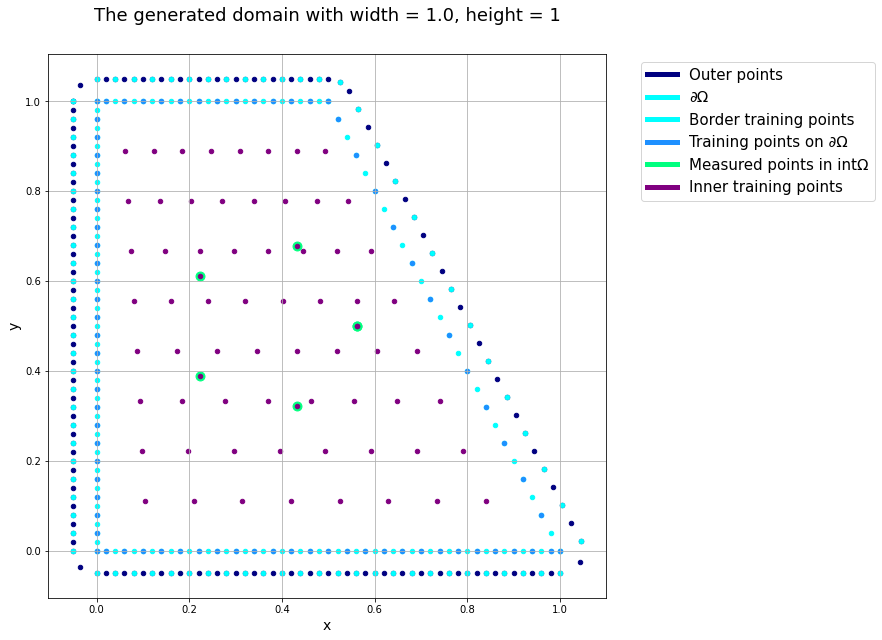

In [ ]:
# Setting the parameters of the domain
rectangle_width = 0.5
rectangle_height = 1
triangle_width = 0.5
border_dist = 0.05
number_of_points_inside = 5
density = 50
n_gon = 5
s = 8

# Setting the number of training points to generate
# Option1: if side_str is set 'top' the the following variables should be set to determine the training points 
# in the lower part of the top border
# Option2: if the side_str is set as 'left', 'bottom' or 'right', the amount of all training data should be given
num_points_to_gen_training_border = 3
num_points_to_gen_training_circum = 0

# Setting the inner points for the NN
# Give the following coordinates as floating number
# One digit (if it's and integer or has only one digit), two digits (if it has two or more digits)
[x_coord_circ, y_coord_circ, x_coord_circ_sep, y_coord_circ_sep, inner_x, inner_y, belso_1, belso_2] = mydomain(rectangle_width, rectangle_height, triangle_width, border_dist, density, n_gon, s)

x_inner_requested = inner_x
y_inner_requested = inner_y

# Calling the calling_circ_training_inner function
results_temp = calling_circ_training_inner(rectangle_width, rectangle_height, triangle_width, border_dist, num_points_to_gen_training_border, num_points_to_gen_training_circum, x_inner_requested, y_inner_requested)
# return [ [x_border, y_border], [x_coordinates, y_coordinates], [x_training_border, y_training_border], [x_training_circum, y_training_circum], [x_inner_training, y_inner_training] ]
# Putting the coordinates into lists
border_coord = results_temp[0]
circum_coord = results_temp[1]
border_training_coord = results_temp[2]
circum_training_coord = results_temp[3]
inner_training_coord = results_temp[4]

border_vis = True
circum_vis = True
border_training_vis = True
circum_training_vis = True
inner_mesured_vis = True
inner_training_vis = True

# Setting the visibility boolean list
visibility = [border_vis, circum_vis, border_training_vis, circum_training_vis, inner_mesured_vis, inner_training_vis]

# Setting the savefig variable
savefig = False

# Plotting the domain
rect_plot(border_coord, circum_coord, border_training_coord, circum_training_coord, [inner_x, inner_y], inner_training_coord, visibility, savefig)

# Creating the Neural Network

In [ ]:
# Creating the NN

# Calling the domain generation

border_training_coord_all_x = []
border_training_coord_all_y = []
circum_training_coord_all_x = []
circum_training_coord_all_y = []
inner_training_coord_all_x = []
inner_training_coord_all_y = []
x_inner_requested = []
y_inner_requested = []


results = calling_circ_training_inner(rectangle_width, rectangle_height, triangle_width, border_dist, num_points_to_gen_training_border, num_points_to_gen_training_circum, x_inner_requested, y_inner_requested)
# return [[x_border, y_border], [x_coordinates, y_coordinates], [x_training_border, y_training_border], [x_training_circum, y_training_circum], [x_inner_training, y_inner_training], [x_ngon, y_ngon]]

border_training_coord_all_x += list(results[2][0])
border_training_coord_all_y += list(results[2][1])
circum_training_coord_all_x += list(results[3][0])
circum_training_coord_all_y += list(results[3][1])
inner_training_coord_all_x += list(results[4][0])
inner_training_coord_all_y += list(results[4][1])
x_inner_requested += list(results[5][0])
y_inner_requested += list(results[5][1])

# Calling the radial function calculator function - psi_calculator

psi_input = np.array(psi_calculator([circum_training_coord_all_x, circum_training_coord_all_y], [border_training_coord_all_x, border_training_coord_all_y]))
psi_output = np.array(psi_calculator([x_inner_requested, y_inner_requested], [border_training_coord_all_x, border_training_coord_all_y]))

laplace_psi_input = np.array(laplace_psi([inner_training_coord_all_x, inner_training_coord_all_y], [border_training_coord_all_x, border_training_coord_all_y]))
laplace_psi_output = np.array(laplace_psi([x_inner_requested, y_inner_requested], [border_training_coord_all_x, border_training_coord_all_y]))

psi_training_input = np.concatenate((psi_input,laplace_psi_input))
psi_training_output = np.concatenate((psi_output,laplace_psi_output))

# Calculating distances between circumference points and inner points for initializing weights
init_w_values = np.array(abs_calculator([x_inner_requested, y_inner_requested], [circum_training_coord_all_x, circum_training_coord_all_y])) ** (-1)

# Making the inputs and weights periodic
psi_training_input = np.hstack((np.transpose([psi_training_input[:,-2]]), np.transpose([psi_training_input[:,-1]]), psi_training_input, np.transpose([psi_training_input[:,0]]), np.transpose([psi_training_input[:,1]])))
init_w_values = np.vstack(([init_w_values[2,:]], [init_w_values[-1,:]], init_w_values, [init_w_values[0,:]], [init_w_values[1,:]]))

# Reshaping the training input and output
psi_training_input = np.array(psi_training_input).reshape(np.shape(psi_training_input)[0], np.shape(psi_training_input)[1], 1)
psi_training_output = np.array(psi_training_output).reshape(np.shape(psi_training_output)[0], np.shape(psi_training_output)[1])

# Calling the harmonic function value calculator
harm_function_values_circum = np.array(harm_func(circum_training_coord_all_x, circum_training_coord_all_y))
harm_function_values_inner = np.array(harm_func(x_inner_requested, y_inner_requested))

# Stacking the last 2 and first 2 elements
g_values = np.hstack((harm_function_values_circum[-2], harm_function_values_circum[-1], harm_function_values_circum, harm_function_values_circum[0], harm_function_values_circum[-1]))

# Expanging the dimensions
g_values = np.expand_dims(g_values, 1).T

# Splitting the input into train and test data sets

psi_training_input_train = train_test_split(psi_training_input, train_size = 0.9, test_size= 0.1, random_state = 0)[0]
psi_training_input_test = train_test_split(psi_training_input, train_size = 0.9, test_size= 0.1, random_state = 0)[1]
psi_training_output_train = train_test_split(psi_training_output, train_size = 0.9, test_size= 0.1, random_state = 0)[0]
psi_training_output_test = train_test_split(psi_training_output, train_size = 0.9, test_size= 0.1, random_state = 0)[1]

#print(np.shape(ext_psi_training_input))
print(init_w_values.shape)
print('Shape of the input data set: ', np.shape(psi_training_input))
print('Shape of the output data set: ', np.shape(psi_training_output))

print('Shape of the input train data set: ', np.shape(psi_training_input_train))
print('Shape of the output test data set: ', np.shape(psi_training_output_test))

ValueError: ignored

In [ ]:
# Creating the NN model

model = Sequential()
model.add(Reshape((52, ), input_shape=(52, 1)))
model.add(Dense(3, activation = 'linear',use_bias=False))
model.layers[1].set_weights([init_w_values])

#model.add(CConv2D(1, (1, 3), strides=(1, 1)))
#### itt csak egyetlen, viszont helytől függő konvolúciós ablakot használunk  ##############x
#model.add(LocallyConnected1D(3,3,activation='relu',input_shape=(52, 1)))
#model.add(LocallyConnected1D(3,3,activation='relu'))
#### csak 1 plusz réteggel: 339 paraméter, 0.84 körüli accuracy  (ekkor input shape=(50,1))#############
####  plusz 2 réteggel: 539 paraméter, 0.6 körüli accuracy  #############

### itt két különböző, de rögzített konvolúciós ablakot alkalmazunk  ##########
#model.add(Conv1D(2, 3, activation='relu',input_shape=(52, 1)))
#model.add(Conv1D(2, 3, activation='relu'))    
####  csak plusz 1 réteggel: 299 paraméter, 0.9 körüli accuracy  (ekkor input shape=(50,1))#############
####  plusz 2 réteggel: 313 paraméter, 0.92 körüli accuracy -- ADAM-mal a legjobb #############

model.summary()

# Compiling the model
#opt = SGD(lr=0.1, momentum=0.99)
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.9, amsgrad=False)
model.compile(optimizer=opt, loss='MSE')

# Calling the model
history = model.fit(psi_training_input_train, psi_training_output_train, epochs=500, batch_size=32, validation_data=(psi_training_input_test, psi_training_output_test), verbose=0)

# Getting the weights
model.layers[1].get_weights()[0]
model.layers[1].get_weights()[0].shape

ValueError: ignored

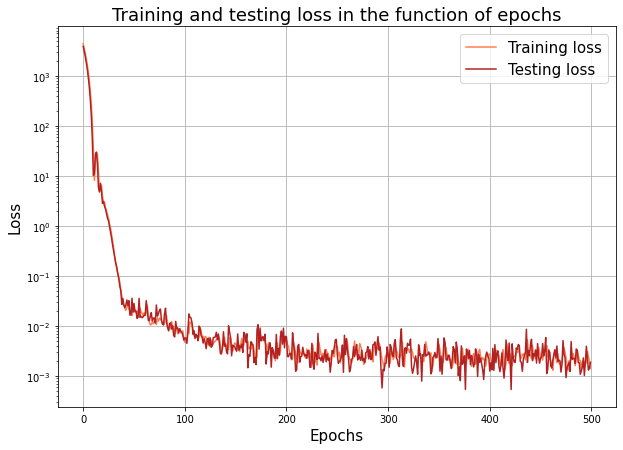

In [ ]:
plt.figure(figsize = (10,7))

plt.plot(history.history['loss'], color = 'coral', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'firebrick', label = 'Testing loss')

plt.title('Training and testing loss in the function of epochs', fontsize = 18)
plt.xlabel('Epochs', fontsize = 15)
plt.yscale('log')
plt.ylabel('Loss', fontsize = 15)

#plt.ylim(0,1)

plt.legend(fontsize = 15)
plt.grid()
plt.show()

In [ ]:
#model.predict(psi_training_input_test)
#psi_training_output_test

In [ ]:
model.predict(g_values)

array([[30.943   , 31.41304 , 26.579306, 25.438538, 28.268171, 30.943   ]],
      dtype=float32)

In [ ]:
harm_function_values_inner

array([28.69140625, 27.77001467, 25.3514432 , 24.6901848 , 26.70007609,
       28.69140625])

In [ ]:
np.shape(psi_training_input_test)

(16, 156, 1)

### Function for calculating the $\Delta\varphi_j(x)= \frac{-4c^2 (c^4 - c^2 r^2 - r^4) }{(c^2-r^2)^4}\exp\{((r/c)^2-1 )^{-1}\}$ values

In [ ]:
# Input1: x coordinates to evaluate φ in
# Input2: y coordinates to evaluate φ in
# Input3: c - concentration of φ

# Output: Δφ_yj(x_i) values

def phi_calculator(x, y, c):
    
    # List for saving the x_i values
    lapl_phi_values = []
    
    # Iterating through the circumference points
    for j in range(0, len(y[0])):
    
        #declaring variable for saving the φ values for all j
        phi_j = []
        
        #iterating through the border points
        for i in range(0,len(x[0])):
            
            #calculating the distances between the border and circumf. values
            beginning_temp = np.array([x[0][i], x[1][i]])
            end_temp = np.array([y[0][j], y[1][j]])
            dist = np.linalg.norm(beginning_temp - end_temp)           
        
            # calculating the φ values
            phi_j.append(float(abs(dist < c))*((-4 * c ** 2 * (c ** 4 - c ** 2 * dist ** 2 - dist ** 4)) * (c ** 2 - dist ** 2) ** (-4)) * (np.exp(1/((dist/c)**2-1))))
        
        #appending the φ values
        lapl_phi_values.append(psi[j])
        
    # Returning with the phi matrix
    return lapl_phi_values